$\begin{align*}
(V,E) &:   \text{ undirected graph G} \\
V(G) &:  \text{set of vertices of graph G}\\ 
E(G) &:  \text{set of edges of graph G} \\
N(v) &: \{u \in V : (u,v) \in E\} \\
\mathcal{L} &: \text{label set} \\
\ell &: \text{Labelling function} \\
(V,E,\ell) &: \text{labeled or attributed graph} \\   
\varphi &: \text{Graph Isomorphism between labeled graphs}\\
\psi_{\varphi} &:  \text{vertex paris implicated by the bijection } \psi_{\varphi}: V_{1} \times V_{1} \rightarrow V_{2} \times V_{2} , \psi_{\varphi}((u,v)) = (\varphi(u), \varphi(v)) \\
G_1 \approx G_2 &: \text{Isomporpsim} \\
\text{Aut}(G) &: \text{isomorphism onto itself} \\
\varphi &: \text{common subgraph isomorphism (CSI)}\\
k_{\text{cal}}(G_1,G_2) &: \text{common subgraph isomorphism (CSI) kernel}\\
k_{\text{sm}}(G_1,G_2)  &: \text{Subgraph Matching Kernel}
\end{align*}$




In [ ]:
#install python-igraph : we use IGraph for manipulating and storing graph data
#install cairocffi : needed for ploting for python-igraph

!pip install python-igraph
!pip install cairocffi

     |████████████████████████████████| 3.2MB 16.1MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=85e479ab34d921360d8c5f7d536d403188b09a38c1ca5922fc2d0f08184ffe03
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi


In [ ]:
import os
import platform
import numpy as np
import igraph as ig
from tqdm import tqdm
from sklearn.svm import SVC
import multiprocessing as mp
from numpy import linalg as LA
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from IPython.core.display import display, Image
from itertools import combinations,combinations_with_replacement

In [ ]:
print("Python Version: ", platform.python_version())
print("Number of processors: ", mp.cpu_count())

Python Version:  3.7.10
Number of processors:  2


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
path = 'data/graph_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#retreving the file names

def get_data(path):
  graph_files = []
  for file in os.listdir(path):
    if file.endswith('gml'):
        graph_files.append(os.path.join(path,file))
  graph_files.sort()
  return graph_files
  

In [ ]:
# making sure that multiple igraph plots are shown in single jupyter cell

def plot(G,id,plt_dims=(200,200)):
  print("Graph "+id,end= "\n\n")
  ig.plot(G,bbox = plt_dims).save('temporary.png') 
  display(Image(filename='temporary.png'))
  os.remove('temporary.png')

Graph G1



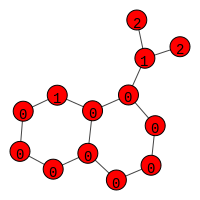

Graph G2



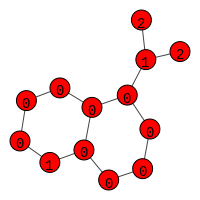

In [ ]:
#sample graph visualization

mutang_path = '/content/drive/MyDrive/data/graph_data/MUTAG'
graph_files = get_data(mutang_path)
G1 = ig.read(graph_files[1])
G2 = ig.read(graph_files[2])
plot(G1,"G1")
plot(G2,"G2")

In [ ]:
#read all .gml files as Igraph objects

def get_Gs(path):
  graph_files = get_data(path)
  Gs = []
  for graph_file in tqdm(graph_files):
    g = ig.read(graph_file)
    Gs.append(g)
  return Gs  



In [ ]:
#scan through all graphs and find total number of unique labels

def get_sizeof_L(graphs):
  """
  Parameters 
  graphs : list of Igraph objects
  Returns 
  sizeof_L : int 
  """

  n_Gs = len(graphs)
  G_node_labels = list()
  for g in graphs:
    g_node_labels = g.vs['label']
    G_node_labels.extend(g_node_labels)
  sizeof_L = len(set(G_node_labels))
  return sizeof_L  



In [ ]:
mutang_path = '/content/drive/MyDrive/data/graph_data/MUTAG'
Gs = get_Gs(mutang_path)
sizeof_L = get_sizeof_L(Gs)
print(" Number of unique labels : ",sizeof_L)

100%|██████████| 188/188 [00:51<00:00,  3.67it/s]

 Number of unique labels :  7


In [ ]:
def modular_product_graph(g1,g2):

  product_graph = ig.Graph()
  for v1 in g1.vs:
    for v2 in g2.vs:
      if v1['label'] == v2['label']:
        product_graph.add_vertex(id=(v1['id'],v2['id']), label=v1['label'],pair=(v1,v2) )

  N_gs = product_graph.vcount()
  for i,j in tqdm(combinations(range(N_gs),2)):  
    u1 = product_graph.vs[i]['pair'][0]
    u2 = product_graph.vs[i]['pair'][1]
    v1 = product_graph.vs[j]['pair'][0]
    v2 = product_graph.vs[j]['pair'][1]


    if (u1 != v1 and u2 != v2):
      e1_idx = g1.get_eid(u1, v1, directed=False, error=False)
      e2_idx = g2.get_eid(u2, v2, directed=False, error=False)
      if (e1_idx != -1 and e2_idx != -1):
        edge1 = g1.es[e1_idx]
        edge2 = g2.es[e2_idx]
        if (edge1['weight'] == edge2['weight']):
          product_graph.add_edge(i,j)
      elif (e1_idx == -1 and e2_idx == -1):
        product_graph.add_edge(i,j)

  return product_graph    

3916it [00:00, 36639.65it/s]


number of vertices in the product graph 89
number of edges in the product graph 2106
Graph product



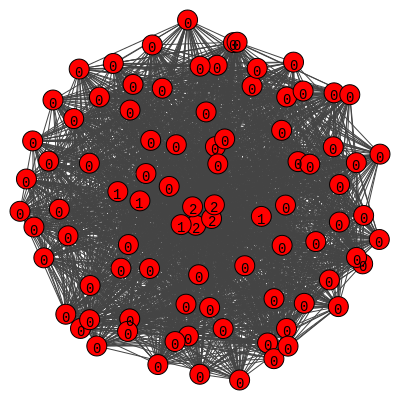

In [ ]:
product_graph = modular_product_graph(G1,G2)
print("number of vertices in the product graph", product_graph.vcount())
print("number of edges in the product graph", product_graph.ecount())
plot(product_graph,"product",plt_dims=(400,400))